Calculate TPR from measured PDD. The PDDs were measured at 100cm FSD, so the field size is set at the surface, and dref is 5cm

Reproduce work that used VBA. Note that data is loaded as string, so have to be carefulf to convert to floats.

On 17th Jan, redo analysis using raw PDD sent by MJ on 12th Jan

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate

import statsmodels.api as sm
from statsmodels import regression

## Load the raw PDD data

In [2]:
PDD = pd.read_table('data/RC_truebeam_6X_raw_PDD.csv', sep= ",", index_col=0)#.astype(np.float); # Load the PDD, convert strings to floats

In [3]:
PDD.index = PDD.index.map(float)       # index and columns are ints for convenience later
PDD.columns = PDD.columns.map(float)   # map values to floats 

PDD.index.rename('Depth_cm', inplace=True)  # rename the cols and index
PDD.columns.rename('Fields_cm', inplace=True)

In [4]:
PDD.head()

Fields_cm,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,12.0,14.0,15.0,16.0,18.0,20.0,25.0,30.0,35.0,40.0,45.0
Depth_cm,,,,,,,,,,,,,,,,,,,,
0.0,67.86,44.78,45.33,46.55,47.30,48.73,49.03,49.93,50.83,51.90,53.71,54.61,55.41,57.01,58.61,62.26,65.30,67.29,69.28,71.27
0.1,67.95,50.37,50.70,52.01,52.77,54.23,54.41,55.35,56.30,56.82,58.63,59.53,60.30,61.84,63.38,66.86,69.82,71.67,73.51,75.35
0.2,69.28,58.63,58.64,60.25,60.92,61.80,62.41,63.25,64.08,64.10,65.79,66.64,67.33,68.73,70.12,73.24,75.83,77.45,79.08,80.71
0.3,72.43,68.21,67.91,69.59,70.18,70.31,71.44,72.12,72.79,72.52,73.98,74.71,75.29,76.46,77.63,80.19,82.27,83.54,84.81,86.08
0.4,77.22,76.78,76.39,77.75,78.26,78.10,79.26,79.81,80.36,80.06,81.24,81.83,82.29,83.21,84.12,86.12,87.71,88.63,89.54,90.45


In [5]:
PDD.shape

(351, 20)

In [6]:
PDD.columns

Float64Index([ 2.0,  3.0,  4.0,  5.0,  6.0,  7.0,  8.0,  9.0, 10.0, 12.0, 14.0,
              15.0, 16.0, 18.0, 20.0, 25.0, 30.0, 35.0, 40.0, 45.0],
             dtype='float64', name='Fields_cm')

(0, 105)

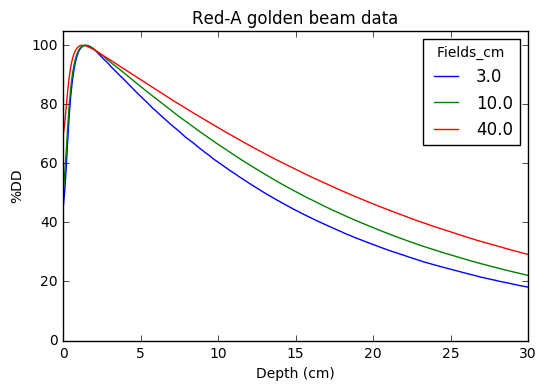

In [7]:
PDD[[3.0, 10.0, 40.0]].plot()
plt.title('Red-A golden beam data')
plt.xlabel('Depth (cm)')
plt.ylabel('%DD')
plt.xlim(0,30)
plt.ylim(0,105)
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Get PDD for field/depth programatically using 2D interp

In [8]:
fields = PDD.columns.values.astype(np.float)
depths = PDD.index.values.astype(np.float)

PDDInterp = interpolate.interp2d(fields, depths, PDD.as_matrix(), kind='linear')  # create the 2D interp

def PDD_(field, depth):  # helper function to get a pdd
    return PDDInterp(field, depth).item()

PDD_(field = 15, depth = 5)

87.05

## Load normalised PSF and get for any field size

Note that only have field sizes 1 - 40 cm but later will need field sizes outside of this range so have to do a polynomial fit out of this range

In [9]:
# Get the NPSF data
NPSF_np = np.genfromtxt('data/NPSF.csv', delimiter= ",")
Fields_NPSF = NPSF_np[0][1:]
Fields_NPSF = Fields_NPSF/10.0   # convert to cm
NPSF = NPSF_np[1][1:]

#plt.plot(Fields_NPSF,NPSF)
Fields_NPSF

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  12.,
        15.,  20.,  25.,  30.,  35.,  40.])

In [10]:
# Linear regression no good
x = Fields_NPSF
y = NPSF
X = sm.add_constant(x)

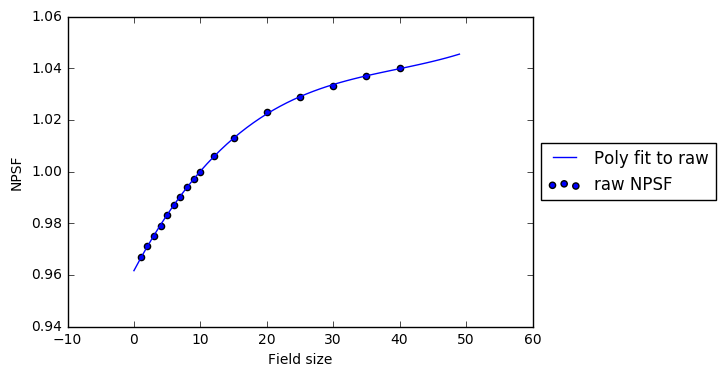

In [11]:
z = np.polyfit(x, y, deg = 3)   # do the poly fit, z is a list of the fit coefficients
p = np.poly1d(z)                # get a polyfit object, pass this an x to get the y

plt.scatter(x,y, label='raw NPSF')

xnew = np.arange(0, 50)
plt.plot(xnew,p(xnew), label='Poly fit to raw')
plt.xlabel('Field size')
plt.ylabel('NPSF')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [12]:
p(20)

1.0222835059706576

In [13]:
NPSF_ = p    # just reassign as used later

In [14]:
NPSF_(20)

1.0222835059706576

# Calculated TPR

For a given field, depth and reference depth, calulate the TPR

In [15]:
def TPR(field, depth, depth_ref):   # copied straigth from EXCEL, distances are cm
    # 'Calculate TPR for SSD f = 100cm'
    f = 100.0   # The SSD under ref conditions, 100 cm
    S = field
    d = depth
    dr = depth_ref
    correction = ((f + d) / (f + dr)) ** 2
    PDD_d = PDD_(((S * f) / (f + d)), d)
    PDD_dr = PDD_(((S * f) / (f + dr)), dr)
    NPSF_d = NPSF_(((S * f) / (f + d)))
    NPSF_dr = NPSF_(((S * f) / (f + dr)))
    TPR = (PDD_d / PDD_dr) * (NPSF_d / NPSF_dr) * correction
    return round(TPR, 3)

print(TPR(3, 5, 5))   # 0.84 agrees with EXCEL calcs

1.0


# Generate TPR table

As with my project work I had to iterate over the data frame to apply the funciton taking in index/column values

In [16]:
fields = PDD.columns.values.astype(np.float)
depths = PDD.index.values.astype(np.float)

columns = len(fields)
rows = len(depths)
TPR_array = np.zeros((rows,columns))  # init an empty array

In [17]:
PDD.columns.values#.astype(np.float)

array([  2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  12.,  14.,
        15.,  16.,  18.,  20.,  25.,  30.,  35.,  40.,  45.])

In [18]:
TPR_array.shape

(351, 20)

In [19]:
row = 0
for depth in depths:
    column = 0
    for field in fields:
        TPR_array[row][column] = TPR(field, depth, 5.0)
        column = column + 1
    row = row + 1  

In [20]:
TPR_df = pd.DataFrame(data=TPR_array, index=depths, columns=fields)  # 1st row as the column names

In [21]:
TPR_df.index.name = 'Depth_mm'
TPR_df.columns.name = 'Field_size'

In [22]:
TPR_df[1:2]

Field_size,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,12.0,14.0,15.0,16.0,18.0,20.0,25.0,30.0,35.0,40.0,45.0
Depth_mm,,,,,,,,,,,,,,,,,,,,
1.0,1.110,1.097,1.084,1.078,1.071,1.066,1.064,1.062,1.060,1.054,1.051,1.051,1.050,1.050,1.050,1.049,1.048,1.046,1.044,1.043
1.1,1.123,1.110,1.097,1.091,1.084,1.078,1.075,1.073,1.070,1.064,1.061,1.060,1.059,1.058,1.058,1.056,1.054,1.051,1.049,1.048
1.2,1.133,1.119,1.107,1.100,1.093,1.087,1.083,1.080,1.077,1.072,1.068,1.067,1.065,1.064,1.063,1.061,1.058,1.055,1.053,1.051
1.3,1.139,1.126,1.114,1.106,1.099,1.093,1.089,1.086,1.083,1.077,1.073,1.071,1.070,1.068,1.067,1.064,1.060,1.057,1.055,1.053
1.4,1.144,1.130,1.119,1.110,1.102,1.096,1.092,1.089,1.086,1.081,1.076,1.074,1.072,1.071,1.069,1.065,1.061,1.058,1.056,1.054
1.5,1.147,1.132,1.121,1.112,1.105,1.098,1.094,1.091,1.088,1.082,1.078,1.075,1.074,1.072,1.070,1.066,1.062,1.059,1.056,1.054
1.6,1.147,1.133,1.122,1.113,1.106,1.099,1.096,1.092,1.088,1.083,1.078,1.076,1.074,1.072,1.070,1.065,1.062,1.059,1.056,1.054
1.7,1.145,1.133,1.121,1.113,1.106,1.099,1.096,1.092,1.088,1.082,1.078,1.076,1.074,1.071,1.069,1.065,1.061,1.058,1.055,1.053
1.8,1.143,1.132,1.120,1.111,1.104,1.098,1.094,1.091,1.088,1.082,1.077,1.075,1.073,1.070,1.068,1.064,1.060,1.057,1.055,1.053


In [23]:
TPR_df.to_csv('Pandas_TPR.csv')

In [24]:
TPR_df.shape

(351, 20)

## Load published data

In [25]:
Published_TPR = pd.read_table('data/Published_TPR_MJ.csv', sep= ",", index_col=0).astype(np.float); 

Published_TPR.index = Published_TPR.index.map(float)       # index and columns are ints for convenience later
Published_TPR.columns = Published_TPR.columns.map(float)   # map values to floats 

Published_TPR.index.rename('Depth_cm', inplace=True)  # rename the cols and index
Published_TPR.columns.rename('Fields_cm', inplace=True)

In [26]:
Published_TPR.head()

Fields_cm,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,...,18.0,19.0,20.0,22.0,24.0,26.0,28.0,30.0,35.0,40.0
Depth_cm,,,,,,,,,,,,,,,,,,,,,
1.4,1.13,1.12,1.11,1.10,1.10,1.09,1.09,1.09,1.08,1.08,...,1.07,1.07,1.07,1.07,1.07,1.06,1.06,1.06,1.06,1.06
2.0,1.13,1.12,1.11,1.10,1.09,1.09,1.09,1.08,1.08,1.08,...,1.07,1.07,1.07,1.06,1.06,1.06,1.06,1.06,1.06,1.05
3.0,1.09,1.08,1.07,1.07,1.07,1.06,1.06,1.06,1.06,1.05,...,1.05,1.05,1.05,1.04,1.04,1.04,1.04,1.04,1.04,1.04
4.0,1.04,1.04,1.04,1.04,1.03,1.03,1.03,1.03,1.03,1.03,...,1.02,1.02,1.02,1.02,1.02,1.02,1.02,1.02,1.02,1.02
5.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [27]:
Published_TPR.shape

(35, 25)

## Get difference of calculated and published TPR

Published TPR has only 25 fields and 35 depths, find fields/depths common to my calculated TPR and published TPR

In [28]:
common_fields = list(set(Published_TPR.columns.values) & set(TPR_df.columns.values))
# common_fields

In [29]:
common_depths = list(set(Published_TPR.index.values) & set(TPR_df.index.values))
# common_depths

In [30]:
difference_df = TPR_df.loc[common_depths, common_fields] - Published_TPR.loc[common_depths, common_fields]
difference_df

Field_size,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,35.0,12.0,40.0,14.0,15.0,16.0,18.0,20.0,30.0
Depth_mm,,,,,,,,,,,,,,,,,
2.0,-0.002,-0.005,-0.002,0.000,0.005,0.000,-0.003,0.004,-0.005,-0.002,0.003,0.004,0.001,-0.001,-0.003,-0.005,-0.003
3.0,-0.003,0.000,0.005,0.000,-0.003,0.004,0.001,-0.002,-0.001,0.005,-0.003,0.002,0.000,-0.001,-0.003,-0.004,0.001
4.0,0.005,0.001,-0.001,-0.004,0.004,0.002,0.001,0.000,0.000,-0.002,-0.001,-0.003,-0.004,-0.005,0.005,0.004,0.001
5.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
6.0,-0.004,-0.001,0.002,0.003,-0.005,-0.004,-0.003,-0.002,-0.002,0.000,-0.001,0.001,0.002,0.002,0.004,0.005,-0.002
7.0,0.004,-0.001,0.004,-0.004,-0.001,0.002,0.004,-0.004,-0.004,0.000,-0.002,0.003,0.004,0.005,-0.003,-0.001,0.004
8.0,0.003,0.000,-0.005,-0.001,0.004,-0.002,0.002,0.004,0.004,-0.001,-0.004,0.003,-0.005,-0.003,0.000,0.003,0.001
9.0,0.004,0.002,-0.003,0.003,-0.001,0.004,-0.002,0.002,0.001,-0.001,0.004,0.004,-0.004,-0.001,0.002,-0.004,-0.003
10.0,-0.003,-0.005,0.002,-0.002,0.004,0.001,-0.005,0.000,-0.002,-0.002,0.001,0.004,-0.003,0.000,0.005,-0.001,0.003


In [31]:
difference_df.max().max()

0.0050000000000000044

In [32]:
difference_df.mean().mean()

-3.865546218487995e-05

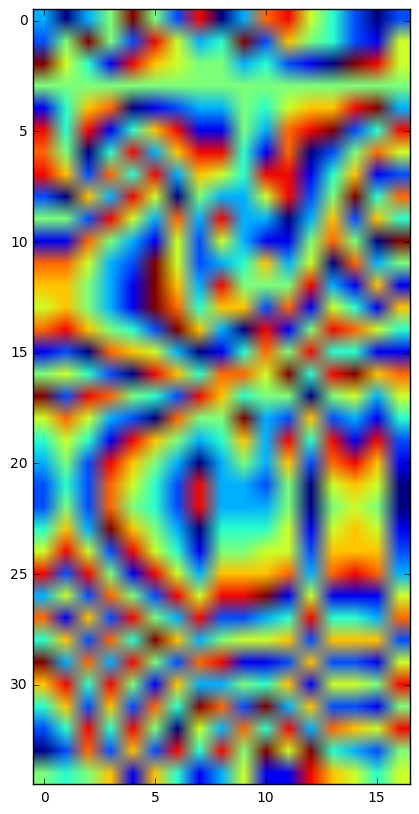

In [33]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(difference_df.as_matrix())